# Entrenamiento y evaluación

In [1]:
%run ./utils.ipynb
from datasets import Image as HFImage
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import (
    AutoImageProcessor, 
    AutoModelForImageClassification,
    TrainingArguments, 
    Trainer,
)
from collections import Counter
import numpy as np
from evaluate import load
import json
import random
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

/mnt/802AC4E62AC4D9F4/tp fundamentos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


El modelo escogido fue la CNN ResNet-18 de Microsoft, pre-entrenado en el dataset ImageNet con 11M de parametros.

**ATENCION: Los pesos resultantes del mejor entrenamiento fueron subidos a HuggingFace. Para repetir los resultados del TP sin tener que repetir entrenamiento mantener RETRAIN=False** 

In [2]:
RETRAIN = False

if RETRAIN:
    MODEL_NAME = "microsoft/resnet-18"
else:
    MODEL_NAME = "fdshdrwu/weld-classifier"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

# Transformaciones

Se definen 2 tipos distintos de transformaciones
1) Obligatorias (cropping, normalizacion, resizing, y conversión a tensor). Estas se aplican a todas los imágenes, tanto de entrenamiento como validacion, como preprocesamiento necesario antes del entrenamiento del modelo.
2) De data augmentation (aplicadas aleatoriamente). Estas se aplican de dos formas distintas: **1)** a todo el dataset de entrenamiento, para impedir que se repitan las mismas imágenes en cada epoch y **2)**  específicamente a copias de las imágenes de clases subrepresentadas, para aumentar su cantidad. Estas son:

- Espejado en el eje vertical
- Blurreo gaussiano
- Modificacion de contraste y color
- Escalado (de 80% a 100%). 

Se puede aplicar hasta un máximo de 2 transformaciones a cada imagen (la cantidad específica en cada caso es definida aleatoriamente).



In [3]:
CORTE_VERTICAL = 300

# Transformaciones estandard de ResNet
base_tfms = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),
])

# Define al azar que transformaciones aplicar
class RandomApply:
    def __init__(self, transforms_list, max_apply=None):
        self.transforms = transforms_list
        self.max_apply = max_apply if max_apply is not None else len(transforms_list)
    
    def __call__(self, img):
        n_apply = random.randint(0, min(self.max_apply, len(self.transforms)))
        
        if n_apply == 0:
            return img
        
        selected = random.sample(self.transforms, k=n_apply)
        for t in selected:
            img = t(img)
        return img

# Para cropear los primeros 300 pixeles de arriba de la imagen (no contienen detalles de la soldadura)
class FixedCrop:
    def __init__(self, left, width):
        self.left = left
        self.width = width

    def __call__(self, img):
        w, h = img.size  
        return F.crop(
            img,
            top=0,
            left=self.left,
            height=h,
            width=self.width
        )

augmentation_tfms = RandomApply([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.0)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ], max_apply=2)

def crop_transform(img):
    w, h = img.size
    return img.crop((0, CORTE_VERTICAL, w, h))
    

# Declaración de datasets y balanceo de clases

Se definen dos datasets 
- Uno pensado para realizar balanceo de las clases desbalanceadas con las transformaciones y metodología declaradas arriba (para entrenamiento).
- Uno que únicamente realiza las transformaciones obligatorias (para validación y testeo).

In [4]:
def compute_augmentations_needed(dataset, target_ratio=0.20):
    """Calcula la cantidad de imagenes que hay que agregar de cada etiqueta."""
    labels = dataset["label"]
    total = len(labels)
    target_count = int(total * target_ratio)
    
    label_counts = Counter(labels)
    augmentations_needed = {}
    for label, count in label_counts.items():
        needed = target_count - count
        if needed > 0:
            augmentations_needed[label] = needed
    
    return augmentations_needed


class BalancedAugmentationDataset(Dataset):
    """Dataset que compensa la las clases menos representadas mediante transformaciones."""
    def __init__(self, hf_dataset, augmentations_needed, base_transform, 
                 augmentation_transforms, crop_fn):
        self.hf_dataset = hf_dataset
        self.base_transform = base_transform
        self.augmentation_tfms = augmentation_transforms
        self.crop_fn = crop_fn
        
        all_labels = hf_dataset["label"]
        
        label_to_indices = {}
        for idx, label in enumerate(all_labels):
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(idx)
        
        self.samples = list(range(len(all_labels)))
        for label, num_needed in augmentations_needed.items():
            indices = label_to_indices[label]
            for i in range(num_needed):
                self.samples.append(indices[i % len(indices)])  
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        original_idx = self.samples[idx]
        item = self.hf_dataset[original_idx]
        image = item["image"].convert("RGB")
        label = item["label"]
        
        image = self.crop_fn(image)
        image = self.augmentation_tfms(image)
        image = self.base_transform(image)
        
        return {"pixel_values": image, "labels": label}


class SimpleDataset(Dataset):
    """Dataset basico que solo aplica las transformaciones obligatorias."""
    def __init__(self, hf_dataset, base_transform, crop_fn):
        self.hf_dataset = hf_dataset
        self.base_transform = base_transform
        self.crop_fn = crop_fn
    
    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item["image"].convert("RGB")
        label = item["label"]
        
        image = self.crop_fn(image)
        image = self.base_transform(image)
        
        return {"pixel_values": image, "labels": label}

train_dataset = load_image_dataset("train")
validation_dataset = load_image_dataset("validation")

train_dataset = train_dataset.cast_column("image", HFImage())
validation_dataset = validation_dataset.cast_column("image", HFImage())
train_dataset = train_dataset.shuffle(seed=42)

label_feature = train_dataset.features["label"]
id2label = {i: name for i, name in enumerate(label_feature.names)}
label2id = {name: i for i, name in enumerate(label_feature.names)}

print(f"Cantidad de muestras de entrenamiento pre-aumentacion: {len(train_dataset)}")

aug_needed = compute_augmentations_needed(train_dataset, target_ratio=0.20)
print(f"Cantidad de imagenes requeridas para cada etiqueta: {aug_needed}")

train_dataset = BalancedAugmentationDataset(
    hf_dataset=train_dataset,
    augmentations_needed=aug_needed,
    base_transform=base_tfms,
    augmentation_transforms=augmentation_tfms,
    crop_fn=crop_transform
)

val_dataset = SimpleDataset(
    hf_dataset=validation_dataset,
    base_transform=base_tfms,
    crop_fn=crop_transform
)

print(f"Cantidad de muestras de entrenamiento post-aumentacion: {len(train_dataset)}")
print(f"Cantidad de muestras de validacion: {len(val_dataset)}")

Casting to class labels: 100%|██████████| 3900/3900 [00:00<00:00, 875122.28 examples/s]


Cantidad de muestras de entrenamiento pre-aumentacion: 26666
Cantidad de imagenes requeridas para cada etiqueta: {5: 2514, 1: 3550, 3: 1305, 4: 2380}
Cantidad de muestras de entrenamiento post-aumentacion: 36415
Cantidad de muestras de validacion: 3900


# Metricas

Se escoge F1 como la metrica a maximizar, pues representa mejor el rendimiento del clasificador que _accuracy_ o _recall_ (las limitaciones de estas son bien conocidas)

In [5]:
f1 = load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return f1.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )

# Entrenamiento

In [ ]:
BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4
EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

steps_per_epoch = len(train_dataset) // (
    BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
)
logging_steps = steps_per_epoch // 4

model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True).to(device)

training_args = TrainingArguments(
    output_dir="./training_results",
    remove_unused_columns=True,
    eval_strategy="steps",
    eval_steps=logging_steps,
    save_strategy="steps",
    save_steps=logging_steps,
    logging_strategy="steps",
    logging_steps=logging_steps,
    learning_rate=1e-5,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, 
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    warmup_ratio=0.1,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="f1",
    push_to_hub=False
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

if RETRAIN:
    trainer.train()

Loading weights: 100%|██████████| 122/122 [00:00<00:00, 829.60it/s, Materializing param=resnet.encoder.stages.3.layers.1.layer.1.normalization.weight]              
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


# Grafico de _loss_ vs _epochs_

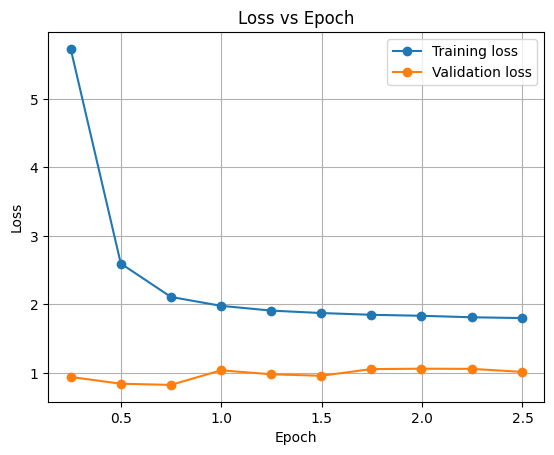

In [7]:
with open("./trainer_state.json") as f:
    state = json.load(f)

log_history = state["log_history"]

train_epochs = []
train_losses = []

eval_epochs = []
eval_losses = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])  

    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"]) 

plt.plot(train_epochs, train_losses, label="Training loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

Se puede observar que el modelo converge muy rápidamente (a mitad de la primera _epoch_) y luego se llega a una meseta.

# Matriz de confusion y reporte de clasificacion

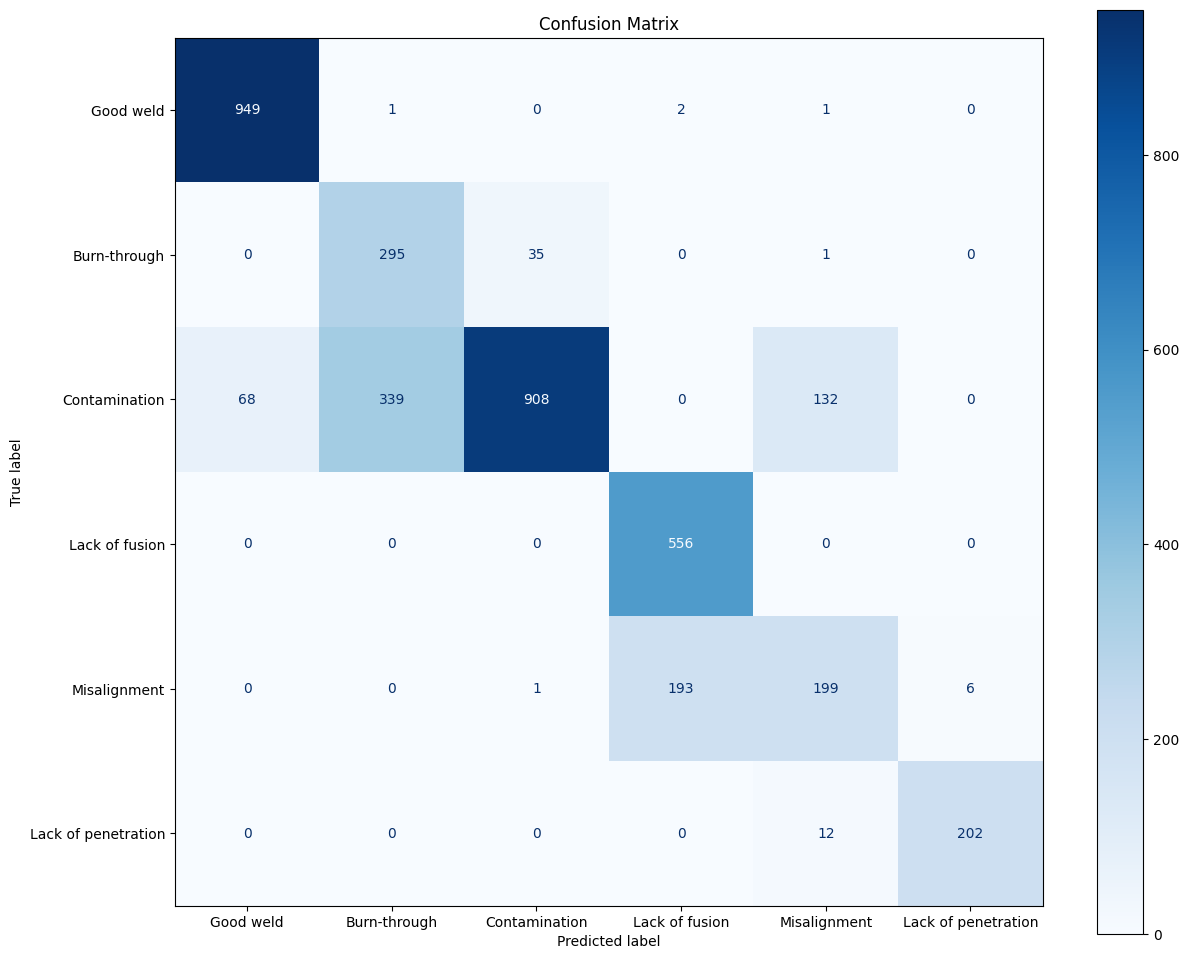

                     precision    recall  f1-score   support

          Good weld       0.93      1.00      0.96       953
       Burn-through       0.46      0.89      0.61       331
      Contamination       0.96      0.63      0.76      1447
     Lack of fusion       0.74      1.00      0.85       556
       Misalignment       0.58      0.50      0.53       399
Lack of penetration       0.97      0.94      0.96       214

           accuracy                           0.80      3900
          macro avg       0.77      0.83      0.78      3900
       weighted avg       0.84      0.80      0.80      3900



In [8]:
class_names = ["Good weld", "Burn-through", "Contamination", "Lack of fusion", "Misalignment", "Lack of penetration"]
outputs = trainer.predict(val_dataset)
pred = outputs.predictions.argmax(axis=-1)
true = outputs.label_ids
draw_confusion_matrix(true, pred, class_names)
draw_classification_report(true, pred, class_names)

# Comparacion con algoritmo de parte 1

Casting to class labels: 100%|██████████| 200/200 [00:00<00:00, 99804.97 examples/s]


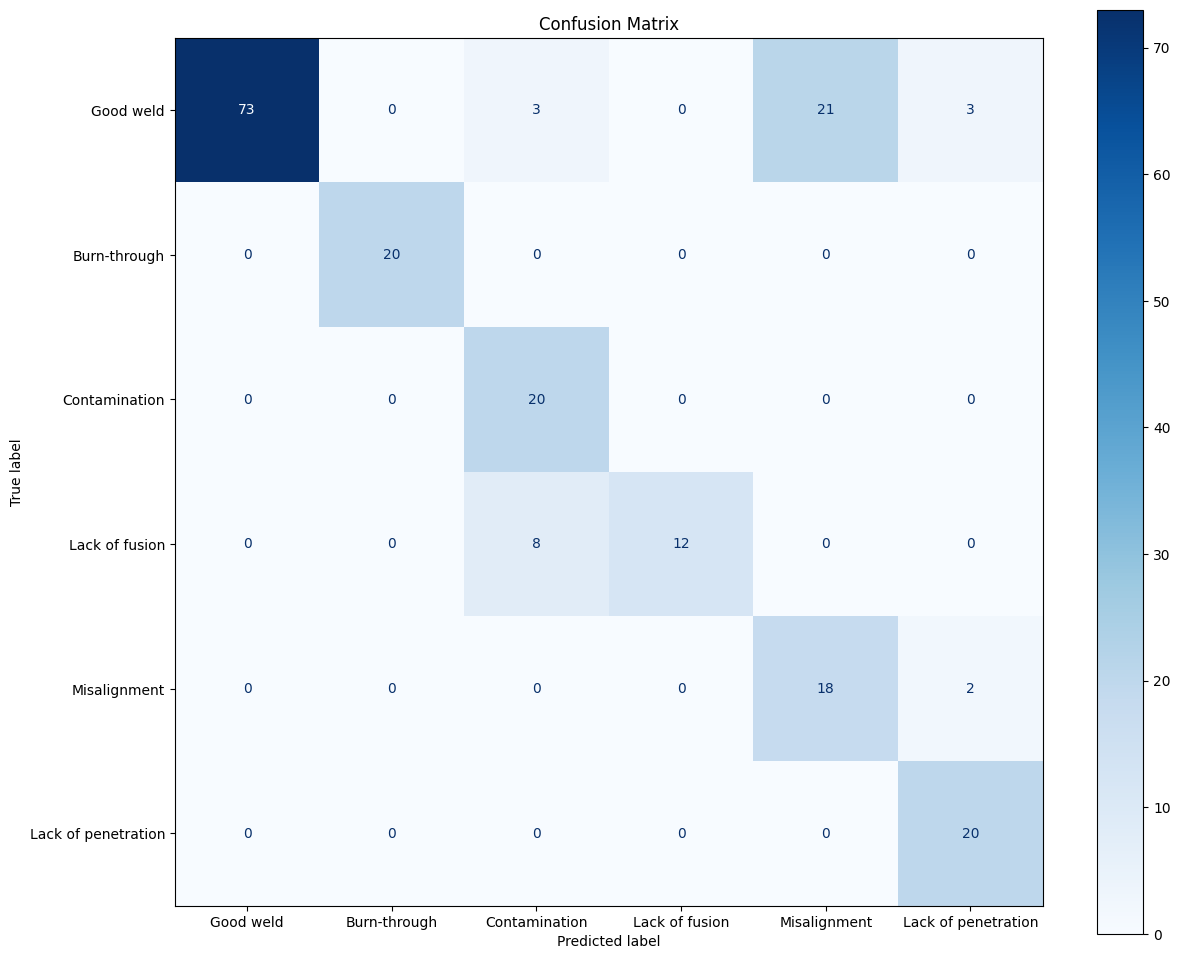

                     precision    recall  f1-score   support

          Good weld       1.00      0.73      0.84       100
       Burn-through       1.00      1.00      1.00        20
      Contamination       0.65      1.00      0.78        20
     Lack of fusion       1.00      0.60      0.75        20
       Misalignment       0.46      0.90      0.61        20
Lack of penetration       0.80      1.00      0.89        20

           accuracy                           0.81       200
          macro avg       0.82      0.87      0.81       200
       weighted avg       0.89      0.81      0.83       200



In [9]:
test_dataset = load_image_dataset("test")
test_dataset = test_dataset.cast_column("image", HFImage())
test_dataset = SimpleDataset(
    hf_dataset=test_dataset,
    base_transform=base_tfms,
    crop_fn=crop_transform
)
outputs = trainer.predict(test_dataset)
pred = outputs.predictions.argmax(axis=-1)
true = outputs.label_ids
draw_confusion_matrix(true, pred, class_names)
draw_classification_report(true, pred, class_names)


Comparando el rendimiento del modelo con el algoritmo de la parte 1 observamos:
- Ambos presentan buen rendimiento en _burn through_
- El modelo tiene mucho mejor rendimiento en _lack of penetration_ 
- Al catalogar _contamination_, el modelo tiende a captar ejemplos de _lack of fusion_. El algoritmo no presenta esa tendencia.
- Ambos tienen un rendimiento similar en _lack of fusion_.
- _Misalignment_ obtiene resultados considerablemente peores, y es el principal responsable de catalogar incorrectamente ejemplos de buenas soldaduras.
